# <center> Machine Learning Programming Exercise 5:</center> 
# <center> <ins>Supervised classification </ins></center> 

| <font size=6>Monôme / binôme</font> | <font size=6>Noms</font> | <font size=6>Prénoms</font>   |
|:-------------:     |:-----------   |:------  |
| binôme 1  | <span>ROUDAUT</span> | <span>Tanguy</span>     |
| binôme 2         | <span>DUBEE</span> | <span>Melvin</span>     | 


## 1. Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:

<img src="https://drive.google.com/uc?export=view&id=1cS7gN2XAYBMmcmyhUjmtQRDlL44_wERM" style="width:600px;height:400px ;" />

L'objectif est d'écrire un ou plusieurs scripts permettant de mettre en oeuvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des patchs
* évaluation du classifieur appris
* comparaison et analyse des performances de différents classifieurs

<img src="https://drive.google.com/uc?export=view&id=1yz-HuFs3zn7Q_AwXflOqdFFjyEAocf1s" />

Le TP est globalement organisé de la manière suivante:

**Données**

Il s'agira d'entraîner les classifieurs à partir de descripteurs extraits grâce à un algorithme performant d'analyse de textures appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à des bancs de filtres (succession de filtres) ; à chaque niveau un ou plusieurs descripteurs sont calculés). 
 
**Prétraitements**

Aucun autre prétraitement ne sera réalisé. 

**Ensembles de données**

Les deux ensembles de données (apprentissage et test) seront composés de 2/3 et 1/3 de la base totale d'images. 

**Algorithmes** 

Concernant les algorithmes supervisés de machine learning, l'objectif est de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).


**Travail demandé**

<span style="color:red">**Dans cet exercice, il vous est demandé de fournir un seul rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un jupyter notebook ou d'un pdf. Il est de plus conseillé de faire tourner les codes sur [google colab](https://colab.research.google.com/?hl=fr) si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire). Il est également conseillé de répondre aux questions par des phrases pour obtenir la totalité des points**.</span>



## Fichiers inclus dans le starter code pour cette séance
* **seafloorClassification_data.npz** - fichier contenant les données nécessaires



# 2. Découverte de la base de patchs

## 2.1 Imports des packages python


In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# on supprime les warnings pénibles de scikit-learn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# numpy
import numpy as np

# links with google drive and colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')	
  import sys
  code_folder = '/content/gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/'
  sys.path.append(code_folder)
  # !ls "/content/gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification"
  %cd "$code_folder"
  !ls "$code_folder"
   

## 2.2 Chargement et examen des données

**Utiliser les lignes de code suivantes permettant de charger les données comprises dans le fichier __seafloorClassification_data.npz__**

In [2]:
# ---------------------------------------------------------------------------------------------------------------
# LOAD Data, Features, Labels
# ---------------------------------------------------------------------------------------------------------------

tmp = np.load('seafloorClassification_data.npz',allow_pickle=True)

image_values = tmp['image_values'] # images sonar
label_names = tmp['label_names'] # types de fond marin
feature_values = tmp['feature_values'] # features extraits avec le scaterring operator
instance_nb = tmp['instance_nb'] # nb d'images sonar
feature_nb = tmp['feature_nb'] # nb de features

##### **<ins>Question 2.2.1:</ins> Ecrire du code permettant d'afficher quelques patchs (comme la première image de ce notebook, chaque patch a une taille de 200x200)**

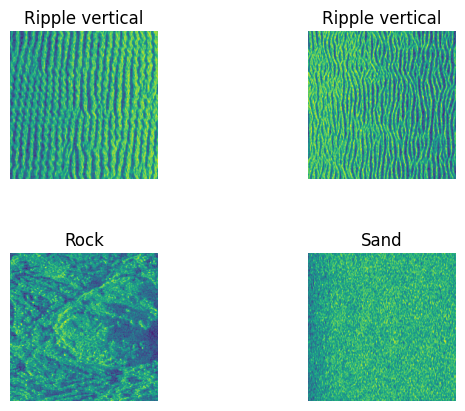

In [3]:
index = np.random.choice(len(image_values), 4, replace=False) # sélection de 4 images aléatoire dans l'ensemble de données 
images = [np.reshape(image, (200, 200)) for image in image_values[index]] # reshape des images de dimension 400000 en tableau de 200px par 200px puis stockage dans une liste
names = label_names[index] # On récupère leurs noms pour faire un affichage cohérent 

for i, img in enumerate(images):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(names[i])
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

**<ins>Question 2.2.2: </ins> Ecrire du code permettant de donner quelques statistiques de chaque descripteur extrait des images grâce au scattering operator.**

In [4]:
for n_feature in range(feature_nb):
    feature_descriptor = feature_values[:, n_feature] # il y a 4 features, donc on récupère toutes les données de chaque features

    print("Feature", n_feature, " :")
    print("\t> Mean: ", np.mean(feature_descriptor)) # calcul et affichage de la moyenne
    print("\t> Std:", np.std(feature_descriptor))  # calcul et affichage de l'écart type
    print("\t> Median:", np.median(feature_descriptor), "\n") # calcul et affichage de la median

Feature 0  :
	> Mean:  1976.764728305124
	> Std: 178.55727141093564
	> Median: 1940.9969039461025 

Feature 1  :
	> Mean:  30.605339159653763
	> Std: 9.98416952667193
	> Median: 28.211177297168398 

Feature 2  :
	> Mean:  21.486941156728236
	> Std: 13.396320735374514
	> Median: 15.359648942141654 

Feature 3  :
	> Mean:  30.876079604633407
	> Std: 11.027577810406473
	> Median: 27.61810908300077 

Feature 4  :
	> Mean:  43.39810779837543
	> Std: 10.259108518958692
	> Median: 42.35776872917822 



**<ins>Question 2.2.3: commentez ces statistiques</ins>** 

On remarque pour les trois dernières features que nous avons des valeurs proches l'une de l'autre, ce qui n'est pas le cas de la première. L'écarte type pour la feature 1 est de 178.55 et 9.98 pour la 2. 
Il est donc important de les normalisés pour la suite du tp

## 3. Traitements

## 3.1 Normalisation des descripteurs 

**<ins>Question 3.1.1:</ins> Écrire des lignes de code permettant de [centrer et réduire](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin. Proposez et mettez en oeuvre un procédé pour vérifier cette normalisation.**


In [5]:
# Nous avons réutiliser notre fonction de normalisation utilisées dans le TP4, la formule est la même, seulement les données change 
feature_values_norm = np.zeros((instance_nb, feature_nb))

for n_feature in range(feature_nb):
    feature_descriptor = feature_values[:, n_feature] 

    mu = np.mean(feature_descriptor, axis=0)
    feature_norm = feature_descriptor - mu

    sigma = np.std(feature_norm, axis=0, ddof=1)
    feature_values_norm[:, n_feature] = feature_norm/sigma

**<ins>Question 3.1.2</ins>: Pourquoi doit-on faire cette normalisation?**

Cela permet de mettre les données sur la même échelles, un écart trop important entre les différentes valeurs peut 

## 3.2 Séparation des données en ensembles 

**<ins>Question 3.2.1:</ins> Écrire des lignes de code permettant de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split): un pour l'apprentissage et un pour le test en proportions 2/3-1/3.**


In [6]:
# la doc scikit-learn nous aide à réaliser deux ensembles, à partir des données de l'énoncé. Cette fonction retourne les deux ensembles (image, label, feature) en respectant les proportions données en argument
image_train, image_test, label_train, label_test, feature_train, feature_test = train_test_split(image_values, label_names, feature_values, test_size=0.33, random_state=42) 

**<ins>Question 3.2.2:</ins> Pourquoi doit-on faire cela?**

Pour entrainer et évaluer un modèle de prédiction, notre jeu de données est découpé en trois groupes:
- Training set: Données utilisées pour entrainer notre modèle.
- Validation set: Données utilisées pour ajuster les hyper-paramètres de notre modèle.
- Test set: Données inconnues par le modèle et utilisées pour l'évaluer. Il est très important pour mettre à l'épreuve notre modèle 

### 3.3 Gestion des labels

**<ins>Question 3.2.3:</ins> Écrire des lignes de code permettant de disposer des labels pour chaque ensemble de données dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms vers indices, indices vers [one-hot-encoding](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features), noms vers one-hot-encoding).**


In [7]:
# Cette première partie permet de renomer nos différent label sous forme numérique, par exemple Posidonia sera 0 et Ripple verticale 1 sous forme
# de tableau [0, 5, 2, ..., 1, 0]
label_encoder = LabelEncoder()
label_indice_train = label_encoder.fit_transform(label_train)
label_indice_test = label_encoder.transform(label_test)


# Cette seconde classe permet d'encoder les labels des différents ensembles en one-hot. Par exemple précedement nous avions 3 ici ce sera [0. 0. 1. 0. 0. 0.]
one_hot_encoder = OneHotEncoder(sparse=False)
label_one_hot_train = one_hot_encoder.fit_transform(label_train.reshape(-1, 1))
label_one_hot_test = one_hot_encoder.transform(label_test.reshape(-1, 1))
indice_one_hot_train = one_hot_encoder.fit_transform(label_indice_train.reshape(-1, 1))
indice_one_hot_test = one_hot_encoder.transform(label_indice_test.reshape(-1, 1))

**<ins>Question 3.2.4:</ins> Etudiez la répartition du nombre de données (d'images) pour chaque <ins>type de fonds marins et pour chaque ensemble de données</ins>. Est-ce important? Pourquoi?**

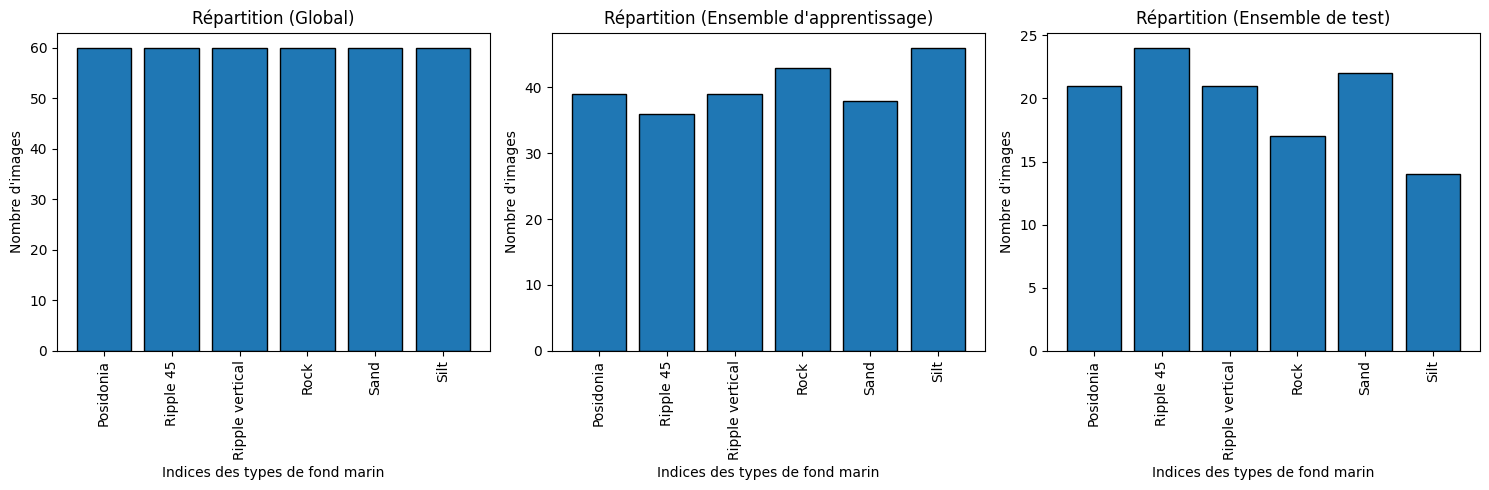

In [8]:
# cette portion de code est utile pour afficher les noms des répartitions 
# elle n'a aucun intérêt dans autre que l'affichage
label_encoder = LabelEncoder() 
label_indice_name = label_encoder.fit_transform(label_names) # réutilisation de la fonction précédente

# Récupération des noms des différents sol.
classes = np.arange(len(set(label_indice_name)))
classe_name = [label_names[np.where(label_indice_name == 0)][0], \
               label_names[np.where(label_indice_name == 1)][0], \
               label_names[np.where(label_indice_name == 2)][0], \
               label_names[np.where(label_indice_name == 3)][0], \
               label_names[np.where(label_indice_name == 4)][0], \
               label_names[np.where(label_indice_name == 5)][0]]
# fin de la portion                

# Liste des élements à afficher depuis la boucle
label_indice = [label_indice_name, label_indice_train, label_indice_test]
label_ensemble_type = ["Global", "Ensemble d'apprentissage", "Ensemble de test"]

plt.figure(figsize=(15, 5))
for i, label in enumerate(label_indice): # Un subplot par sous graphique "Global", "Ensemble d'apprentissage", "Ensemble de test"
    plt.subplot(1, 3, i+1)
    plt.bar(classes, np.bincount(label), edgecolor='black', align='center')
    plt.xticks(classes, classe_name, rotation='vertical') 
    plt.xlabel('Indices des types de fond marin')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition (%s)' % (label_ensemble_type[i]))

plt.tight_layout()

**_Double cliquez ici pour écrire votre réponse ici!_**


## 4. Approche supervisée à partir des descripteurs du scattering operator

## 4.1 Apprentissage des classifieurs


**<ins>Question 4.1.1:</ins> Faire la liste expliquée des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) les plus importants des algorithmes: [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).Vous vous concentrerez sur les hyperparamètres que nous avons rencontré précédemment (cours et TPs).**

##### Régression Logistique:

```python 
model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100, class_weight=None)
```

- **penalty**: La norme utilisée pour la pénalisation ('l1', 'l2', 'elasticnet', 'none').
- **C**: Inverse de la force de régularisation; valeurs plus faibles spécifient une régularisation plus forte.
- **solver**: L'algorithme utilisé dans l'optimisation ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga').
- **max_iter**: Le nombre maximum d'itérations pour l'optimisation.
- **class_weight**: Spécifie le poids relatif des classes pour l'entraînement déséquilibré.

##### Réseaux de Neurones (Multi-layer Perceptron):

```python 
model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, 
                      learning_rate='constant', learning_rate_init=0.001, max_iter=200)
```

- **hidden_layer_sizes**: La taille des couches cachées.
- **activation**: La fonction d'activation utilisée ('identity', 'logistic', 'tanh', 'relu').
- **solver**: L'optimiseur pour la minimisation de la perte ('lbfgs', 'sgd', 'adam').
- **alpha**: Terme de régularisation pour les poids.
- **learning_rate**: Taux d'apprentissage pour les mises à jour de poids ('constant', 'invscaling', 'adaptive').
- **learning_rate_init**: Taux d'apprentissage initial utilisé. C'est la taille de pas dans la mise à jour des poids.
- **max_iter**: Le nombre maximum d'itérations pour l'optimisation.

##### Random Forests:

```python 
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                               min_samples_split=2, min_samples_leaf=1)
```

- **n_estimators**: Le nombre d'arbres dans la forêt.
- **max_features**: Le nombre de caractéristiques à considérer pour la meilleure division à chaque nœud.
- **max_depth**: La profondeur maximale de chaque arbre dans la forêt.
- **min_samples_split**: Le nombre minimum d'échantillons requis pour diviser un nœud interne.
- **min_samples_leaf**: Le nombre minimum d'échantillons requis pour être à un nœud feuille.

##### Support Vector Machines (SVM):

```python 
model = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', class_weight=None)
```

- **C**: Paramètre de régularisation pour contrôler le coût des erreurs.
- **kernel**: Le noyau utilisé pour la transformation de l'espace ('linear', 'poly', 'rbf', 'sigmoid').
- **degree**: Degré du noyau polynomial (utilisé avec le noyau polynomial).
- **gamma**: Coefficient du noyau ('scale', 'auto' ou un nombre flottant).
- **class_weight**: Spécifie le poids relatif des classes pour l'entraînement déséquilibré.



**<ins>Question 4.1.2</ins>: Réalisez l'apprentissage successif des modèles: régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn. Les valeurs des hyper-paramètres seront choisis comme les valeurs par défaut de scikit-learn.**

In [9]:
logistic_regression_model = LogisticRegression() # Création de notre modéle de régression logistique avec les valeurs par défauts (on ne rempli rien)
logistic_regression_model.fit(feature_train, label_train) # Apprentissage avec notre ensemble "train"

mlp_model = MLPClassifier() # Création de notre modéle de réseau de neuronne
mlp_model.fit(feature_train, label_train) # Apprentissage avec notre ensemble "train"

svm_model = SVC() # Création de notre modéle de support vector machines
svm_model.fit(feature_train, label_train) # Apprentissage avec notre ensemble "train"

random_forest_model = RandomForestClassifier() # Création de notre modéle de random forests
random_forest_model.fit(feature_train, label_train) # Apprentissage avec notre ensemble "train"

RandomForestClassifier()

**<ins>Question 4.1.3</ins>: A l'aide des fonctions fournies, évaluer les modèles appris avec la procédure d'évaluation des performances pour les grands jeux de données en calculant et en affichant la matrice de confusion, puis les [métriques extraites de cette matrice](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). Commenter.**

In [10]:
# Pour réaliser nos prédictions nous allons utilisés notre ensemble de test, notre model n'a pas encore rencontré cette ensemble, 
# on le test donc dans des conditions réel
logistic_regression_predictions = logistic_regression_model.predict(feature_test) # réalisation de la prédiction grâce à notre modèle de régression logistique 
print("Matrice de Confusion - Régression Logistique :")
print(confusion_matrix(label_test, logistic_regression_predictions)) # affichage de la matrice de confusion
print("\nRapport de Classification - Régression Logistique :")
print(classification_report(label_test, logistic_regression_predictions)) # affichage des performences de nos prédictions

mlp_predictions = mlp_model.predict(feature_test)# réalisation de la prédiction grâce à notre modèle de réseau de neuronne
print("\nMatrice de Confusion - Réseaux de Neurones :")
print(confusion_matrix(label_test, mlp_predictions))
print("\nRapport de Classification - Réseaux de Neurones :")
print(classification_report(label_test, mlp_predictions))

svm_predictions = svm_model.predict(feature_test)# réalisation de la prédiction grâce à notre modèle de support vector machines
print("\nMatrice de Confusion - SVM :")
print(confusion_matrix(label_test, svm_predictions))
print("\nRapport de Classification - SVM :")
print(classification_report(label_test, svm_predictions))

random_forest_predictions = random_forest_model.predict(feature_test)# réalisation de la prédiction grâce à notre modèle de random forests
print("\nMatrice de Confusion - Random Forest :")
print(confusion_matrix(label_test, random_forest_predictions))
print("\nRapport de Classification - Random Forest :")
print(classification_report(label_test, random_forest_predictions))


Matrice de Confusion - Régression Logistique :
[[15  4  0  0  0  2]
 [ 2 14  2  0  4  2]
 [ 1  0 17  0  1  2]
 [ 0  0  0 17  0  0]
 [ 0  0  0  0 21  1]
 [ 4  0  0  0  0 10]]

Rapport de Classification - Régression Logistique :
                 precision    recall  f1-score   support

      Posidonia       0.68      0.71      0.70        21
      Ripple 45       0.78      0.58      0.67        24
Ripple vertical       0.89      0.81      0.85        21
           Rock       1.00      1.00      1.00        17
           Sand       0.81      0.95      0.88        22
           Silt       0.59      0.71      0.65        14

       accuracy                           0.79       119
      macro avg       0.79      0.80      0.79       119
   weighted avg       0.80      0.79      0.79       119


Matrice de Confusion - Réseaux de Neurones :
[[20  1  0  0  0  0]
 [18  5  0  1  0  0]
 [19  0  0  1  0  1]
 [ 0  0  0 17  0  0]
 [ 1  0  0  0  1 20]
 [14  0  0  0  0  0]]

Rapport de Classification 

## 4.2 Première évaluation (biaisée) des classifieurs

**<ins>Question 4.2.1</ins>: Le jeu de données étant petit, la procédure précédente n'est pas adaptée. Vous évaluerez les performances par [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html\#computing-cross-validated-metrics) et reporterez la moyenne et l'écart-type de la métrique `accuracy`. Commenter**

In [11]:
# Calcul de la cross-validation à l'aide de la fonction scikit-learn puis affichage de la moyenne et de l'écart type du scores obtenus pour chaque modèle 

logistic_regression_scores = cross_val_score(logistic_regression_model, feature_test, label_test, scoring='accuracy')
print("Régression Logistique - Accuracy: Mean =", logistic_regression_scores.mean(), ", Std =", logistic_regression_scores.std())

mlp_scores = cross_val_score(mlp_model, feature_test, label_test, scoring='accuracy')
print("Réseaux de Neurones - Accuracy: Mean =", mlp_scores.mean(), ", Std =", mlp_scores.std())

svm_scores = cross_val_score(svm_model, feature_test, label_test, scoring='accuracy')
print("SVM - Accuracy: Mean =", svm_scores.mean(), ", Std =", svm_scores.std())

random_forest_scores = cross_val_score(random_forest_model, feature_test, label_test, scoring='accuracy')
print("Random Forest - Accuracy: Mean =", random_forest_scores.mean(), ", Std =", random_forest_scores.std())

Régression Logistique - Accuracy: Mean = 0.7648550724637682 , Std = 0.04921938423100165
Réseaux de Neurones - Accuracy: Mean = 0.16956521739130434 , Std = 0.12201917410383217
SVM - Accuracy: Mean = 0.21811594202898554 , Std = 0.0391170132645385
Random Forest - Accuracy: Mean = 0.8913043478260869 , Std = 0.04951985380657937


**_Double cliquez ici pour écrire votre réponse ici!_**



## 4.3 Optimisation des hyper-paramètres du modèle

Le jeu de données étant très petit, la valeur des hyper-paramètres doit être fixée de manière optimale en évaluant les modèles par cross validation sur l'ensemble de training.

**<ins>Question 4.3.1</ins>:** Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold):
* pour la **<ins>Régression logistique:</ins>**:
    * C: 0.001, 0.01,0.1,1,10
    * penalty = 'l1', 'l2', 'elasticnet', 'None'
    
* pour le **<ins>réseau de neurones</ins>:**
    * hidden_layer_sizes: une couche de 100 neurones, 2 couches de 100 neurones, 3 couches de 100 neurones
    * activation: 'logistic', 'tanh', 'relu'
    * alpha: 0.0001, 0.001, 0.01, 0.1, 1, 10

* pour le **<ins>Random Forest</ins>:**
    * n_estimators: 1, 10, 100, 500, 1000
    * max_depth: 5, 10, 20
    * min_samples_leaf: 1, 5, 10

* pour le **<ins>SVM</ins>:**
    * kernel: 'rbf' 
    * C: 1e3, 5e3, 1e4, 5e4, 1e5, 1e6
    * gamma: 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5


N'hésitez pas à fixer le paramètre `verbose` pour comprendre ce qui est fait.

In [12]:
param_grid_logistic_regression = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}
# création de notre grille contenant toute les possibilités de tests avec nos hyperparamétre avec 5 plis (5 tests différents) pour tous nos modèle
grid_search_logistic_regression = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_logistic_regression, cv=5) 
grid_search_logistic_regression.fit(feature_train, label_train) # calcul des résultats pour notre ensemble de données


param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
grid_search_mlp = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid_mlp, cv=5)
grid_search_mlp.fit(feature_train, label_train)


param_grid_random_forest = {
    'n_estimators': [1, 10, 100, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_random_forest, cv=5)
grid_search_random_forest.fit(feature_train, label_train)


param_grid_svm = {
    'kernel': ['rbf'],
    'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e6],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5]
}
grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm, cv=5)
grid_search_svm.fit(feature_train, label_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0,
                               1000000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1,
                                   0.5],
                         'kernel': ['rbf']})

**<ins>Question 4.3.2</ins>: Donner la valeur des paramètres optimaux pour chaque classifieur.**

In [13]:
# utilisation des résultats précédent, nous récupéront les meilleurs résultats obtenus pour les diffénts hyperparamètre  
# suite au 5 plis 
best_params_logistic_regression = grid_search_logistic_regression.best_params_ 
print("Régression Logistique - Paramètres Optimaux :", best_params_logistic_regression)

best_params_mlp = grid_search_mlp.best_params_
print("Réseaux de Neurones - Paramètres Optimaux :", best_params_mlp)

best_params_random_forest = grid_search_random_forest.best_params_
print("Random Forest - Paramètres Optimaux :", best_params_random_forest)

best_params_svm = grid_search_svm.best_params_
print("SVM - Paramètres Optimaux :", best_params_svm)

Régression Logistique - Paramètres Optimaux : {'C': 0.1, 'penalty': 'l2'}
Réseaux de Neurones - Paramètres Optimaux : {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100)}
Random Forest - Paramètres Optimaux : {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
SVM - Paramètres Optimaux : {'C': 5000.0, 'gamma': 0.0001, 'kernel': 'rbf'}


**_Double cliquez ici pour écrire votre réponse ici!_**



**<ins>Question 4.3.3</ins>: Apprendre le modèle final pour chaque classifieur avec les paramètres optimaux et évaluer leurs performances avec les métriques (precision, recall, f1).**


**_Your commented code below_**

In [14]:
# Le code est le même que pour la question 4.1.2 et 4.1.3, mais cette fois si nous calcullons nos modèle avec les meilleurs hyperparamètres obtenus précédement

model_logistic_regression = LogisticRegression(**best_params_logistic_regression)
model_logistic_regression.fit(feature_train, label_train)
predictions_logistic_regression = model_logistic_regression.predict(feature_test)
report_logistic_regression = classification_report(label_test, predictions_logistic_regression)
print("Régression Logistique; Performances :\n", report_logistic_regression)

print("\n==================================================\n\n")

model_mlp = MLPClassifier(**best_params_mlp)
model_mlp.fit(feature_train, label_train)
predictions_mlp = model_mlp.predict(feature_test)
report_mlp = classification_report(label_test, predictions_mlp)
print("Réseaux de Neurones; Performances :\n", report_mlp)

print("\n==================================================\n\n")

model_random_forest = RandomForestClassifier(**best_params_random_forest)
model_random_forest.fit(feature_train, label_train)
predictions_random_forest = model_random_forest.predict(feature_test)
report_random_forest = classification_report(label_test, predictions_random_forest)
print("Random Forest; Performances :\n", report_random_forest)

print("\n==================================================\n\n")

model_svm = SVC(**best_params_svm)
model_svm.fit(feature_train, label_train)
predictions_svm = model_svm.predict(feature_test)
report_svm = classification_report(label_test, predictions_svm)
print("SVM; Performances :\n", report_svm)
         

Régression Logistique; Performances :
                  precision    recall  f1-score   support

      Posidonia       0.72      0.62      0.67        21
      Ripple 45       0.76      0.54      0.63        24
Ripple vertical       0.81      0.81      0.81        21
           Rock       1.00      1.00      1.00        17
           Sand       0.81      0.95      0.88        22
           Silt       0.60      0.86      0.71        14

       accuracy                           0.78       119
      macro avg       0.78      0.80      0.78       119
   weighted avg       0.79      0.78      0.78       119






Réseaux de Neurones; Performances :
                  precision    recall  f1-score   support

      Posidonia       0.50      0.33      0.40        21
      Ripple 45       1.00      0.17      0.29        24
Ripple vertical       0.62      0.86      0.72        21
           Rock       1.00      1.00      1.00        17
           Sand       0.81      0.95      0.88        22
           Silt       0.45      0.93      0.60        14

       accuracy                           0.67       119
      macro avg       0.73      0.71      0.65       119
   weighted avg       0.74      0.67      0.63       119




Random Forest; Performances :
                  precision    recall  f1-score   support

      Posidonia       1.00      1.00      1.00        21
      Ripple 45       1.00      0.96      0.98        24
Ripple vertical       0.95      0.95      0.95        21
           Rock       1.00      1.00      1.00        17
           Sand       0.95      0.95      0.95        22
           Si

## 4.4 Evaluation optimale pour les petits jeux de données

**<ins>Question 4.4.1</ins>: Les performances espérées par le modèle final sont biaisées car nous avons un petit jeu de données et nous avons évaluées les performances sur des données vues lors de l'apprentissage ou pour fixer les hyperparamètres. La procédure adaptée pour évaluer proprement les performances dans ce cas se nomme validations croisées imbriquées. Le tutoriel [Nested Cross-Validation for Machine Learning with Python](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) décrit cette procédure. Evaluer les performances pour une validation croisée extérieure (outer) de 4 et intérieure (inner) de 3**.


In [19]:
# création des validations croisées en respectant l'énoncé
cv_outer = KFold(n_splits=4, shuffle=True, random_state=1)
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

# On récupère nos model et hyperparamètres précedent 
models = [model_logistic_regression, model_mlp, model_random_forest, model_svm]
param_grid = [param_grid_logistic_regression, param_grid_mlp, param_grid_random_forest, param_grid_svm]

mean_res = []
std_res = []

for index, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[index], scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True) # calcul des paramètres
    grid_search_svm.fit(feature_train, label_train)# calcul des paramètres avec nos ensembles d'entrainement
    scores = cross_val_score(grid_search, feature_test, label_test, scoring='accuracy', cv=cv_outer, n_jobs=-1) # calcul de la cross validation avec la grid search inner=3 et outer=4

    mean_res.append(scores.mean())
    std_res.append(scores.std())

for i, model in enumerate(models):
    print(f"Model: {model.__class__.__name__}")
    print('Accuracy: %.3f (%.3f)\n\n' % (mean_res[i], std_res[i]))

/Users/tanguyrdt/depot/depot-ensta-python/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tanguyrdt/depot/depot-ensta-python/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Model: LogisticRegression
Accuracy: 0.731 (0.021)


Model: MLPClassifier
Accuracy: 0.757 (0.053)


Model: RandomForestClassifier
Accuracy: 0.891 (0.049)


Model: SVC
Accuracy: 0.757 (0.053)




_Double cliquez ici pour écrire votre réponse ici!_


# 5. Approche supervisée sur données brutes

**<ins>Question 5.1</ins>:** Réalisez l'apprentissage du classifieur random forest en utilisant les fonctions du package scikit-learn sur les valeurs des pixels des images. Pensez vous qu'un autre classifieur donnerait des meilleurs résultats? Analysez les résultats (décrivez et proposez une interprétation de ce qu'il se passe)

In [16]:
# Le code correspond a celui pour la prédiction avec les classificateurs mais cette fois-ci avec les images
model_random_forest.fit(image_train, label_train)
predictions_random_forest = model_random_forest.predict(image_test)
print("Random Forest; Performances :\n", classification_report(label_test, predictions_random_forest))


Random Forest; Performances :
                  precision    recall  f1-score   support

      Posidonia       0.32      0.43      0.37        21
      Ripple 45       0.50      0.21      0.29        24
Ripple vertical       0.86      0.29      0.43        21
           Rock       0.63      0.71      0.67        17
           Sand       0.62      0.91      0.74        22
           Silt       0.57      0.93      0.70        14

       accuracy                           0.55       119
      macro avg       0.58      0.58      0.53       119
   weighted avg       0.58      0.55      0.51       119



**_Your commented code below_**

**_Double cliquez ici pour écrire votre réponse ici!_**


# 6. Analyse finale

**<ins>Question 6.1</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés (et leurs caractéristiques) et des prétraitements effectués.**

**_Double cliquez ici pour écrire votre réponse ici!_**


# 7. Diagramme fonctionnel

**<ins>Question 7.1</ins>:** Réalisez un diagramme fonctionnel décrivant le flux des données au travers de différents blocs (représentant des fonctions) tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, le modèle de machine learning appris, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)

**_Your image here_** <img src="fichierDiagramme.png" />

**<ins>Question 7.2</ins>:**  Mettez vous dans le cadre d'**un jeu de données de grande taille** et réalisez un autre diagramme fonctionnel répondant à la question précédente. 

**_Your image here_** <img src="fichierDiagramme2.png" />